In [18]:
import pandas as pd
import numpy as np

In [19]:
raw_data = pd.read_csv("Bitcoin History.csv")
raw_data.head()

Date     Price      Open      High       Low    Vol. Change %
0  Feb 09, 2024  47,545.4  45,293.3  47,710.2  45,254.2  86.85K    4.97%
1  Feb 08, 2024  45,293.3  44,346.2  45,579.2  44,336.4  66.38K    2.15%
2  Feb 07, 2024  44,339.8  43,088.4  44,367.9  42,783.5  48.57K    2.91%
3  Feb 06, 2024  43,087.7  42,697.6  43,375.5  42,566.8  33.32K    0.91%
4  Feb 05, 2024  42,697.2  42,581.4  43,532.2  42,272.5  39.26K    0.27%

In [20]:
raw_data["Date"][180].replace(",","").split(" ")

['Aug', '13', '2023']

In [21]:
pd.to_datetime("2023-8-13")

Timestamp('2023-08-13 00:00:00')

In [22]:
def parse_date(date:str) ->pd.Timestamp:
    months = {"Jan":1,
              "Feb":2,
              "Mar":3,
              "Apr":4,
              "May":5,
              "Jun":6,
              "Jul":7,
              "Aug":8,
              "Sep":9,
              "Oct":10,
              "Nov":11,
              "Dec":12}
    
    list_date = date.replace(",","").split(" ")

    year = list_date[2]
    day = list_date[1]
    month = months[list_date[0]]

    datetime_date = pd.to_datetime(f"{year}-{month}-{day}")
    
    return datetime_date


In [23]:
raw_data["Date"] = raw_data["Date"].map(parse_date)
raw_data.head()

Date     Price      Open      High       Low    Vol. Change %
0 2024-02-09  47,545.4  45,293.3  47,710.2  45,254.2  86.85K    4.97%
1 2024-02-08  45,293.3  44,346.2  45,579.2  44,336.4  66.38K    2.15%
2 2024-02-07  44,339.8  43,088.4  44,367.9  42,783.5  48.57K    2.91%
3 2024-02-06  43,087.7  42,697.6  43,375.5  42,566.8  33.32K    0.91%
4 2024-02-05  42,697.2  42,581.4  43,532.2  42,272.5  39.26K    0.27%

In [24]:
def split_dates(data:pd.DataFrame) -> pd.DataFrame:
    copy = data.copy()

    copy["day"] = copy["Date"].dt.day
    copy["month"] = copy["Date"].dt.month
    copy["year"] = copy["Date"].dt.year
    copy["day_of_week"] = copy["Date"].dt.day_of_week

    copy = copy.drop("Date", axis=1)

    return copy

df = split_dates(raw_data)
df.head()

Price      Open      High       Low    Vol. Change %  day  month  year  \
0  47,545.4  45,293.3  47,710.2  45,254.2  86.85K    4.97%    9      2  2024   
1  45,293.3  44,346.2  45,579.2  44,336.4  66.38K    2.15%    8      2  2024   
2  44,339.8  43,088.4  44,367.9  42,783.5  48.57K    2.91%    7      2  2024   
3  43,087.7  42,697.6  43,375.5  42,566.8  33.32K    0.91%    6      2  2024   
4  42,697.2  42,581.4  43,532.2  42,272.5  39.26K    0.27%    5      2  2024   

   day_of_week  
0            4  
1            3  
2            2  
3            1  
4            0

In [25]:
df_main = df.drop(["Open","High","Low","Change %"], axis=1)
df_main.head()

Price    Vol.  day  month  year  day_of_week
0  47,545.4  86.85K    9      2  2024            4
1  45,293.3  66.38K    8      2  2024            3
2  44,339.8  48.57K    7      2  2024            2
3  43,087.7  33.32K    6      2  2024            1
4  42,697.2  39.26K    5      2  2024            0

In [26]:
def parse_price(value):
    return float(value.replace(",",""))

def parse_volume(volume):
    if volume == "-":
        return 0
    return float(volume[:4])

df_main["Price"] = df_main["Price"].map(parse_price)
df_main["Vol."] = df_main["Vol."].map(parse_volume)

In [27]:
df_main = pd.get_dummies(df_main,columns=["day_of_week"], drop_first=True)

In [28]:
today = pd.to_datetime("2024-02-09")

covid_start = pd.to_datetime("2020-01-15")
ukr_war = pd.to_datetime("2022-02-24")

print(today - covid_start)
print(today - ukr_war)

1486 days 00:00:00
715 days 00:00:00


In [29]:
print(df.shape[0])

is_covid_array = [True for _ in range(1486)] + [False for _ in range(df.shape[0]-1486)]
is_war = [True for _ in range(715)] + [False for _ in range(df.shape[0]-715)]

print(f"{len(is_covid_array)}    {len(is_war)}")

4955
4955    4955


In [30]:
df_main["is_covid"] = is_covid_array
df_main["is_war"] = is_war

In [31]:
import seaborn as sns

sns.lineplot(df_main,x="month",y="Price")

<AxesSubplot: xlabel='month', ylabel='Price'>

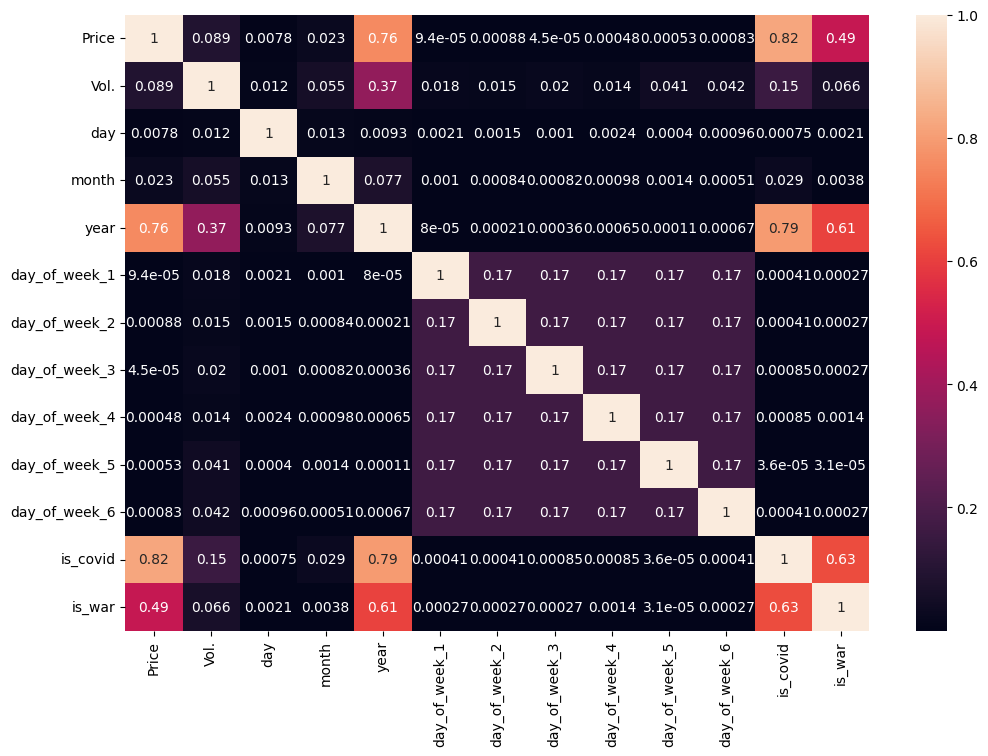

In [32]:
import matplotlib.pyplot as plt

plt.figure().set_size_inches(12,8)
sns.heatmap(abs(df_main.corr()), annot=True)
plt.show()

In [37]:
train = df_main[df_main["year"]<=2023]
test = df_main[df_main["year"]>2023]

In [38]:

def train_test_split(y_true:str,train:pd.DataFrame,test:pd.DataFrame, log:bool, cols_to_drop:list = None) -> tuple:
    
    if cols_to_drop != None:
        X_train = train.drop([y_true] + cols_to_drop, axis=1)
        X_test = test.drop([y_true] + cols_to_drop, axis=1)  
    
    else:
        X_train = train.drop(y_true, axis=1)
        X_test = test.drop(y_true, axis=1)    

    if log == False:
        y_train = train[y_true]
        y_test = test[y_true]
    
    elif log == True:
        y_train = np.log(train[y_true])
        y_test = np.log(test[y_true])

    return X_train,X_test,y_train,y_test

cols_to_drop = ["Price"]

X_train,X_test,y_train,y_test = train_test_split("Vol.",
                                                 train,
                                                 test,
                                                 log=False,
                                                 cols_to_drop=None)

In [39]:
X_train

Price  day  month  year  day_of_week_1  day_of_week_2  day_of_week_3  \
40    42272.5   31     12  2023              0              0              0   
41    42136.7   30     12  2023              0              0              0   
42    42072.4   29     12  2023              0              0              0   
43    42581.1   28     12  2023              0              0              1   
44    43446.5   27     12  2023              0              1              0   
...       ...  ...    ...   ...            ...            ...            ...   
4950      0.1   22      7  2010              0              0              1   
4951      0.1   21      7  2010              0              1              0   
4952      0.1   20      7  2010              1              0              0   
4953      0.1   19      7  2010              0              0              0   
4954      0.1   18      7  2010              0              0              0   

      day_of_week_4  day_of_week_5  day_of_week_6  is_covid  is_war  
40                0              0              1      True    True  
41                0              1              0      True    True  
42                1              0              0      True    True  
43                0              0              0      True    True  
44                0              0              0      True    True  
...             ...            ...            ...       ...     ...  
4950              0              0              0     False   False  
4951              0              0              0     False   False  
4952              0              0              0     False   False  
4953              0              0              0     False   False  
4954              0              0              1     False   False  

[4915 rows x 12 columns]

In [88]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer

lasso_pipe = Pipeline([("scaler",StandardScaler()),( "lasso",Lasso(max_iter=500,alpha=1))])

lasso_pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=1, max_iter=500))])

In [89]:
lasso_pipe["lasso"].coef_

array([-7.29012632e+01,  1.96468296e+00, -7.71429637e-01,  1.55493547e+02,
        0.00000000e+00,  0.00000000e+00,  5.47675436e-02, -0.00000000e+00,
       -8.40673402e+00, -8.45146772e+00, -6.88299929e+00, -3.83344982e+01])

In [90]:
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse

def print_deviations(estimator,X_test,y_test,log_target:bool):
    if log_target == False:
        print(f"MAE: {mae(y_test,estimator.predict(X_test))}")
        print(f"MSE: {mse(y_test,estimator.predict(X_test))}")
        print(f"RMSE: {mse(y_test,estimator.predict(X_test))**0.5}")
    elif log_target == True:
        print(f"RMLSE: {mse(y_test,estimator.predict(X_test))**0.5}")


def plot_results(estimator,X_train,X_test,y_train,y_test):
    """Графическое отображение предсказаний модели"""
    
    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)

    df_train = pd.DataFrame({"X_train_preds":train_preds,
                             "y_train":y_train})
    
    df_test = pd.DataFrame({"X_test_preds":test_preds,
                            "y_test":y_test})
    
    plt.figure().set_size_inches(12,8)

    ax1 = plt.subplot(1,2,1)
    plt.title("Train")
    sns.lineplot(df_train)
    plt.tight_layout()
    # plt.show()

    ax2 = plt.subplot(1,2,2)
    plt.title("Test")
    sns.lineplot(df_test)
    plt.tight_layout()
    # plt.show()

print_deviations(lasso_pipe,X_test,y_test,log_target=False)

MAE: 102.1331280694175
MSE: 11481.063555210107
RMSE: 107.14972494229795


In [91]:
plot_results(lasso_pipe,X_train,X_test,y_train,y_test)

In [68]:
from xgboost import XGBRegressor

xgb_pipe = Pipeline([("scaler",StandardScaler()),("xgb",XGBRegressor(max_depth=1))])

xgb_pipe.fit(X_train,y_train)

print_deviations(xgb_pipe,X_test,y_test,log_target=False)

plot_results(xgb_pipe,X_train,X_test,y_train,y_test)

MAE: 63.2292399597168
MSE: 4740.129767952227
RMSE: 68.84860033400989


0:	learn: 175.2366402	total: 544us	remaining: 26.7ms
1:	learn: 170.3597168	total: 1.06ms	remaining: 25.4ms
2:	learn: 162.8169434	total: 1.51ms	remaining: 23.7ms
3:	learn: 159.1219304	total: 1.95ms	remaining: 22.4ms
4:	learn: 156.1475687	total: 2.58ms	remaining: 23.2ms
5:	learn: 153.4765820	total: 3.2ms	remaining: 23.5ms
6:	learn: 150.8847015	total: 3.78ms	remaining: 23.2ms
7:	learn: 149.5750179	total: 4.35ms	remaining: 22.8ms
8:	learn: 148.1229322	total: 4.8ms	remaining: 21.9ms
9:	learn: 146.7588635	total: 5.45ms	remaining: 21.8ms
10:	learn: 145.8962643	total: 6.19ms	remaining: 21.9ms
11:	learn: 145.1364958	total: 6.89ms	remaining: 21.8ms
12:	learn: 144.3707820	total: 7.45ms	remaining: 21.2ms
13:	learn: 143.7627505	total: 7.95ms	remaining: 20.5ms
14:	learn: 143.1458255	total: 8.43ms	remaining: 19.7ms
15:	learn: 142.5803596	total: 8.95ms	remaining: 19ms
16:	learn: 142.0973059	total: 9.72ms	remaining: 18.9ms
17:	learn: 141.6278967	total: 10.4ms	remaining: 18.6ms
18:	learn: 141.2593341	to

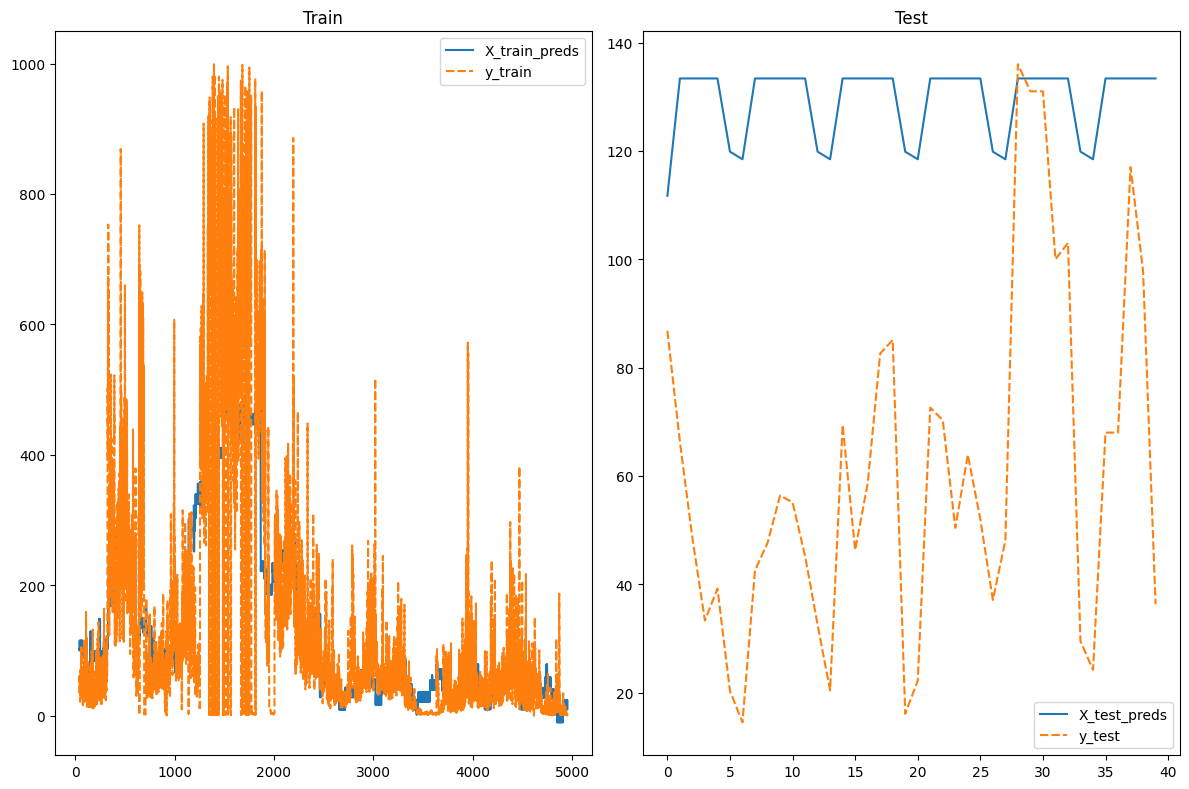

In [65]:
from catboost import CatBoostRegressor

cat_pipe = Pipeline([("scaler",StandardScaler()),("catboost",CatBoostRegressor(iterations=50,depth=1,learning_rate=0.6, random_seed=32))])

cat_pipe.fit(X_train,y_train)

print_deviations(cat_pipe,X_test,y_test,log_target=False)

plot_results(cat_pipe,X_train,X_test,y_train,y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 339
[LightGBM] [Info] Number of data points in the train set: 4915, number of used features: 12
[LightGBM] [Info] Start training from score 139.033833
MAE: 72.58773659475405
MSE: 5939.674077987418
RMSE: 77.06928102679704


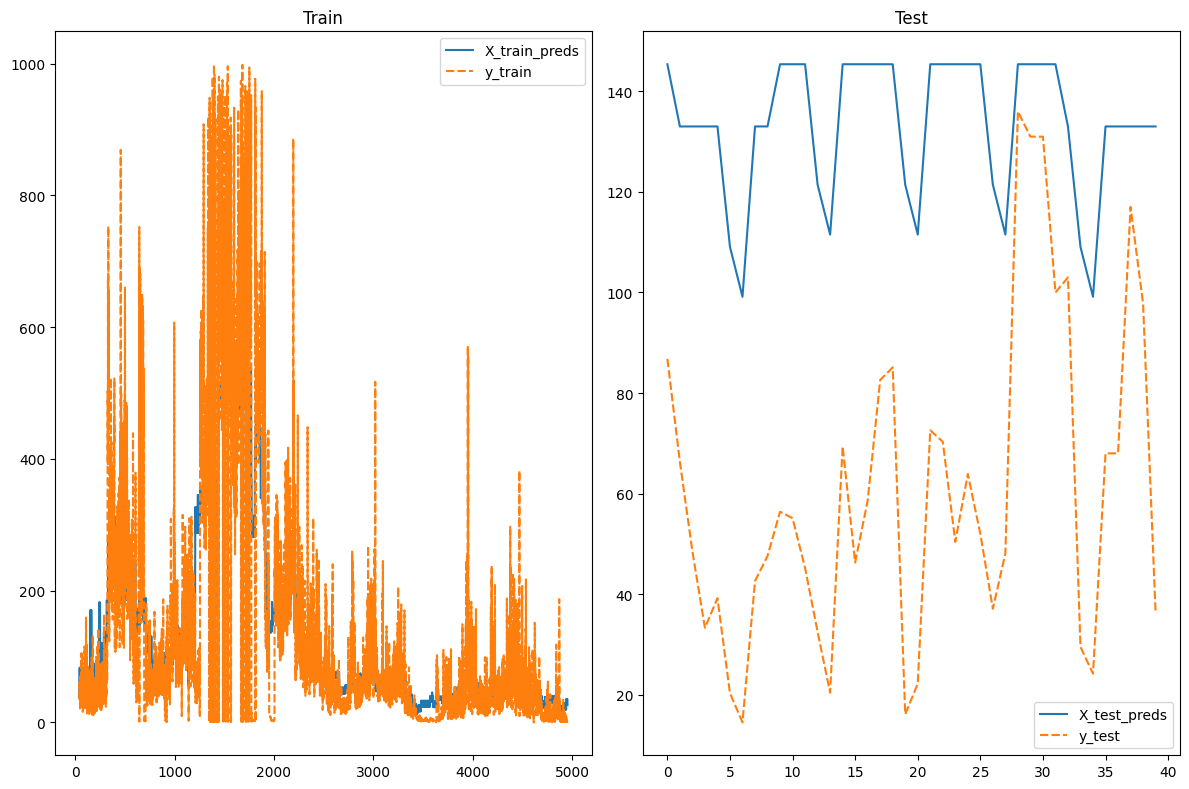

In [79]:
from lightgbm import LGBMRegressor

lgbm_pipe = Pipeline([("scaler",StandardScaler()),("lgbm",LGBMRegressor(max_depth=3,num_leaves=31, n_estimators=40))])

lgbm_pipe.fit(X_train,y_train)

print_deviations(lgbm_pipe,X_test,y_test,log_target=False)

plot_results(lgbm_pipe,X_train,X_test,y_train,y_test)

In [93]:
import pickle as pkl

pkl_filename = "xgb_volume.pkl" 
with open(pkl_filename, 'wb') as file: 
    pkl.dump(xgb_pipe, file)